# Creating A Neural Network To Interpret The Fashion MNIST Zalando.com Data

This dataset was published on kaggle, it is the Fashion-MINST dataset, and is gathered from the Europan online fashion retailer Zalando's website. It is described on kaggle thusly "Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes." Here is a link to that: https://www.kaggle.com/datasets/zalando-research/fashionmnist


In [110]:
import os as os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import subprocess

In [4]:
file_path_test = "/Users/gimle/Data 201/Data 201 project 3/fashion-mnist_test.csv"
file_path_train = "/Users/gimle/Data 201/Data 201 project 3/fashion-mnist_train.csv"

In [10]:
zalando_test = pd.read_csv(file_path_test)
zalando_train = pd.read_csv(file_path_train)

In [12]:
zalando_train.head(3)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0


In [14]:
zalando_test.head(10)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2,0,0,0,0,0,44,105,44,10,...,105,64,30,0,0,0,0,0,0,0
6,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,6,0,0,0,0,0,0,0,1,0,...,174,136,155,31,0,1,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,57,70,28,0,2,0,0,0,0,0


In [16]:
zalando_test.columns

Index(['label', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779', 'pixel780',
       'pixel781', 'pixel782', 'pixel783', 'pixel784'],
      dtype='object', length=785)

In [18]:
zalando_train.columns

Index(['label', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779', 'pixel780',
       'pixel781', 'pixel782', 'pixel783', 'pixel784'],
      dtype='object', length=785)

In [20]:
test_count = zalando_test['label'].value_counts()
print(test_count) 

label
0    1000
1    1000
2    1000
3    1000
8    1000
6    1000
5    1000
4    1000
7    1000
9    1000
Name: count, dtype: int64


In [22]:
train_count = zalando_train['label'].value_counts()
print(train_count) 

label
2    6000
9    6000
6    6000
0    6000
3    6000
4    6000
5    6000
8    6000
7    6000
1    6000
Name: count, dtype: int64


In [107]:
print("The trianing dataset accounts for approximately" , f"{(1/7)*100:.2f}" , "percent of the train + test data")

The trianing dataset accounts for approximately 14.29 percent of the train + test data


In [27]:
# Importing necessary torch packages
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torchmetrics
from torchmetrics import Accuracy
import torch.nn.functional as F
import time 
from time import sleep

## Formatting data: 

In [31]:
# Separate features and labels

features = zalando_train.drop(columns=["label"]).values / 255.0
target = zalando_train["label"].values

features_test = zalando_test.drop(columns=["label"]).values / 255.0
target_test = zalando_test["label"].values

# Convert to PyTorch tensors

features_tensor_train = torch.tensor(features, dtype=torch.float32)
target_tensor_train = torch.tensor(target, dtype=torch.long)

features_tensor_test = torch.tensor(features_test, dtype=torch.float32)
target_tensor_test = torch.tensor(target_test, dtype=torch.long)

In [33]:
# Tensor formatting complete after this step
train_dataset = TensorDataset(features_tensor_train, target_tensor_train)
test_dataset = TensorDataset(features_tensor_test, target_tensor_test)

# Check batch size
train_loader = DataLoader(train_dataset, batch_size=784, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=784, shuffle=False)

## Creating a neural network for multiclass classification

### ReLU

In [37]:
# The neural ReLU network: 
model = nn.Sequential(
    nn.Linear(784, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 256), # extra layer post success
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 128), # extra layer post success
    nn.ReLU(), 
    nn.Linear(128, 10)
    )



In [39]:
# Counting number of parameters in model: 
total = 0

# Calculate the number of parameters in the model
for parameter in model.parameters():
  total += parameter.numel()
print(total)

649738


## Loss function and optimizer

In [42]:
# Define Criterion and optimizer
criterion = nn.CrossEntropyLoss()  

In [44]:
# includes learning rate
# success was also obtained with lr=0.037, momentum=0.917
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer.step()

## Training the model

In [47]:
# storing metrics for visualisation
train_metrics = []

# Training loop
num_epochs = 20 
accuracy_metric = Accuracy(task="multiclass", num_classes=10)

for epoch in range(num_epochs): 
    model.train()
    running_loss = 0.0
    accuracy_metric.reset()
    
    for features, labels in train_loader: 
        # Clearing gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(features)
        # Compute loss and gradients
        loss = criterion(outputs, labels)
        # Then we compute accuracy: 
        accuracy_metric.update(outputs, labels)
        # Backwards pass
        loss.backward()
        # Update parameters 
        optimizer.step()
        # iterate running loss tab
        running_loss += loss.item()
    
    # creates a live list of loss and training accuracy: 
    epoch_accuracy = accuracy_metric.compute()
    avg_loss = running_loss / len(train_loader)
    running_accuracy = float(epoch_accuracy)
    train_metrics.append({
        "epoch": epoch + 1,
        "loss": avg_loss,
        "accuracy": running_accuracy
    })

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}, Accuracy: {epoch_accuracy:.6f}")

train_df = pd.DataFrame.from_dict(train_metrics)

Epoch 1/20, Loss: 2.300495, Accuracy: 0.100533
Epoch 2/20, Loss: 2.286749, Accuracy: 0.267583
Epoch 3/20, Loss: 2.030945, Accuracy: 0.382617
Epoch 4/20, Loss: 1.058454, Accuracy: 0.567817
Epoch 5/20, Loss: 0.831298, Accuracy: 0.685867
Epoch 6/20, Loss: 0.753254, Accuracy: 0.726850
Epoch 7/20, Loss: 0.686172, Accuracy: 0.753167
Epoch 8/20, Loss: 0.636376, Accuracy: 0.772317
Epoch 9/20, Loss: 0.595060, Accuracy: 0.786067
Epoch 10/20, Loss: 0.530182, Accuracy: 0.810667
Epoch 11/20, Loss: 0.494438, Accuracy: 0.826817
Epoch 12/20, Loss: 0.474375, Accuracy: 0.833800
Epoch 13/20, Loss: 0.460067, Accuracy: 0.837617
Epoch 14/20, Loss: 0.432656, Accuracy: 0.848617
Epoch 15/20, Loss: 0.412563, Accuracy: 0.855400
Epoch 16/20, Loss: 0.396966, Accuracy: 0.860633
Epoch 17/20, Loss: 0.389769, Accuracy: 0.861383
Epoch 18/20, Loss: 0.371252, Accuracy: 0.868217
Epoch 19/20, Loss: 0.355199, Accuracy: 0.874267
Epoch 20/20, Loss: 0.346921, Accuracy: 0.876950


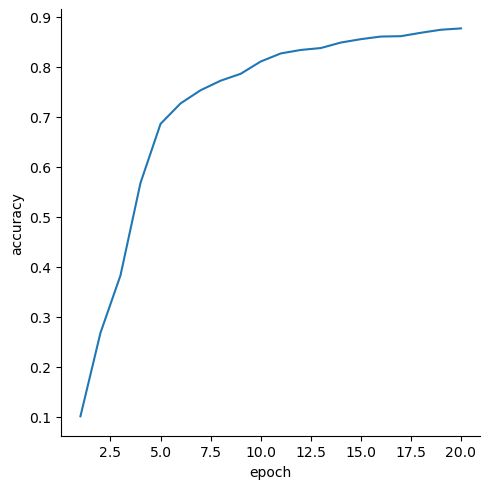

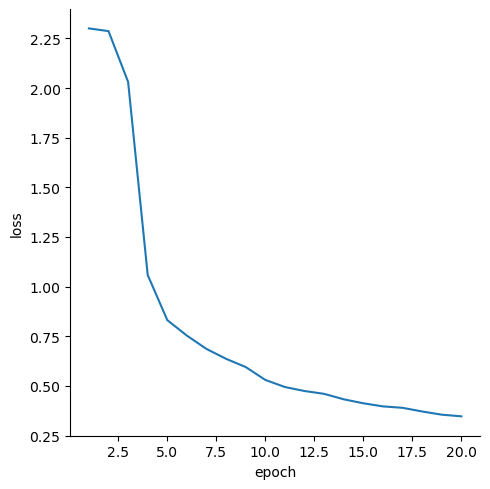

In [49]:
#  visualising model training 

sns.relplot(x='epoch', y='accuracy', data= train_df, kind='line')
sns.relplot(x='epoch', y = 'loss', data = train_df, kind = 'line')
plt.show()


### Calculating success / metrics

In [52]:
# This is for module evaluation, we start by setting the model to evaluate mode
model.eval()
validation_loss = 0.0
accuracy_metric.reset()

with torch.no_grad():
  for features, labels in test_loader:
      # forward
      outputs = model(features)
      # loss
      loss = criterion(outputs, labels)
      validation_loss += loss.item()
      # update accuracy
      accuracy_metric.update(outputs, labels)

validation_loss_epoch = validation_loss/len(test_loader)
validation_accuracy = accuracy_metric.compute()

print(f"Validation Loss: {validation_loss_epoch:.4f}")
print(f"Validation Accuracy: {validation_accuracy:.4f}")

# set back to training mode
model.train()
# reset accuracy metrics 
accuracy_metric.reset()
# Because I need extra help seeing if the task is done: 
print("eval complete") 

Validation Loss: 0.3851
Validation Accuracy: 0.8610
eval complete


### Running the machine on a sample

In [55]:
clothing_labels = {
    0 :"T-shirt/top",
    1 :"Trouser",
    2 :"Pullover",
    3 :"Dress",
    4 :"Coat",
    5 :"Sandal",
    6 :"Shirt",
    7 :"Sneaker",
    8 :"Bag",
    9 :"Ankle boot",
}


In [124]:
# Choose a sample! 
# A challenge for the machine: 2903, 2900
sample_index = 2900




In [126]:
# visualising the image before running it:
sample_features = features_tensor_test[sample_index]
sample_label = target_tensor_test[sample_index]
# Batch dimensions is a big problem
sample_features = sample_features.unsqueeze(0)

You have picked a Coat


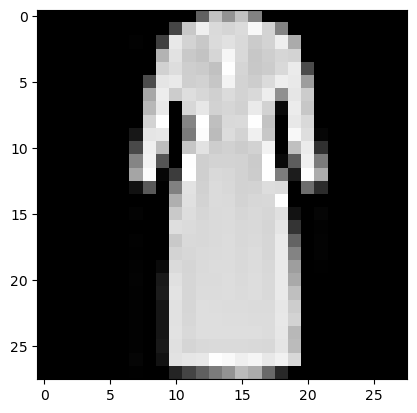

In [128]:
if sample_features.shape[1] == 784:  # Assuming 28x28 images flattened to 784
    plt.imshow(sample_features.view(28, 28).numpy(), cmap='gray')
    print(f"You have picked a {clothing_labels[sample_label.item()]}")
    plt.show()

In [130]:
# Set the model to evaluation mode
model.eval()

# Disable gradient computation
with torch.no_grad():
    outputs = model(sample_features)  # Forward pass
    probabilities = F.softmax(outputs, dim=1)  # Convert logits to probabilities
    predicted_class = torch.argmax(probabilities, dim=1).item()

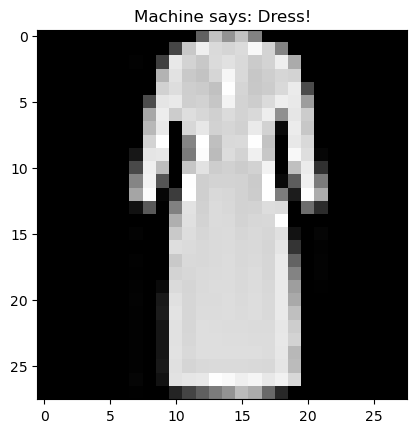

In [132]:
# for visualising the image with tag
if sample_features.shape[1] == 784:  # Assuming 28x28 images flattened to 784
    plt.imshow(sample_features.view(28, 28).numpy(), cmap='gray')
    plt.title(f"Machine says: {clothing_labels[predicted_class]}!")
    plt.show()

### Now with leaky ReLU, 

In [68]:
# The neural Leaky ReLU network: 
model = nn.Sequential(
    nn.Linear(784, 512),
    nn.LeakyReLU(negative_slope = 0.05,inplace = True),
    #nn.Dropout(p = 0.1), too early? 
    nn.Linear(512, 256),
    nn.LeakyReLU(negative_slope = 0.05, inplace = True),
    nn.Dropout(p = 0.1),
    nn.Linear(256, 256), # extra layer post success
    nn.LeakyReLU(negative_slope = 0.05, inplace = True),
    nn.Dropout(p = 0.1),
    nn.Linear(256, 128),
    nn.LeakyReLU(negative_slope = 0.05, inplace = True),
    nn.Dropout(p = 0.1),
    nn.Linear(128, 10)
    )

### Adam optimizer

In [71]:
# Define Criterion and optimizer
criterion = nn.CrossEntropyLoss()  

In [73]:
# Alternative optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
optimizer.step()

### Combined training and validation loop

In [76]:
# Loading bar because this takes time and psychologically it is easier to wait if progress is in sight
def progress(percent=0, width = num_epochs):
    left = width * percent // 100
    right = width - left
    print('\r[', '#' * left, ' ' * right, ']',
          f' {percent:.0f}%',
          sep='', end='', flush=True)
# creating a scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Combined metrics storage
metrics = []
num_epochs = 25
# Training and Validation loop
for epoch in range(num_epochs):
    # Training loop 
    model.train()
    running_loss = 0.0
    accuracy_metric.reset()
    
  
    sleep(0.1)

    for features, labels in train_loader:
        optimizer.zero_grad() 
        
        # forward pass
        outputs = model(features)
        loss = criterion(outputs, labels)
        
        # backward pass
        loss.backward()
        optimizer.step()
        
        # collect metrics
        running_loss += loss.item()
        accuracy_metric.update(outputs, labels)
    
    # compute training metrics
    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_accuracy = accuracy_metric.compute().item()
    # applying the scheduler 
    scheduler.step()
    
    # Validation 
    model.eval()
    validation_loss = 0.0
    accuracy_metric.reset()
    
    with torch.no_grad():
        for features, labels in test_loader:
            
            # forward pass
            outputs = model(features)
            loss = criterion(outputs, labels)
            
            # collect metrics
            validation_loss += loss.item()
            accuracy_metric.update(outputs, labels)
    
    # compute validation metrics
    epoch_validation_loss = validation_loss / len(test_loader)
    epoch_validation_accuracy = accuracy_metric.compute().item()
    epoch = epoch + 1
    # gathering all metrics
    metrics.append({
        "epoch": epoch + 1,
        "train_loss": epoch_train_loss,
        "train_accuracy": epoch_train_accuracy,
        "valid_loss": epoch_validation_loss,
        "valid_accuracy": epoch_validation_accuracy
    })
    # Update and run progress bar
    progress(percent=(epoch) * 100 // num_epochs)
    time.sleep(0.1)


# converting to dataframe for plotting and comparison later
metrics_df = pd.DataFrame.from_dict(metrics)
# reset to training mode
model.train()
accuracy_metric.reset()
# Because I need extra help seeing if the task is done: 
print(" Done! ") 

print(metrics_df.loc[(epoch - 1):])


[####################] 100% Done! 
    epoch  train_loss  train_accuracy  valid_loss  valid_accuracy
24     26    0.169432        0.936483    0.292748          0.9012


In [80]:
# Creating a single metric column in order to plot using seaborn
metrics_long = metrics_df.melt(
    id_vars='epoch', 
    value_vars=['train_loss', 'train_accuracy', 'valid_loss', 'valid_accuracy'],
    var_name='Metric', 
    value_name='Value'
)

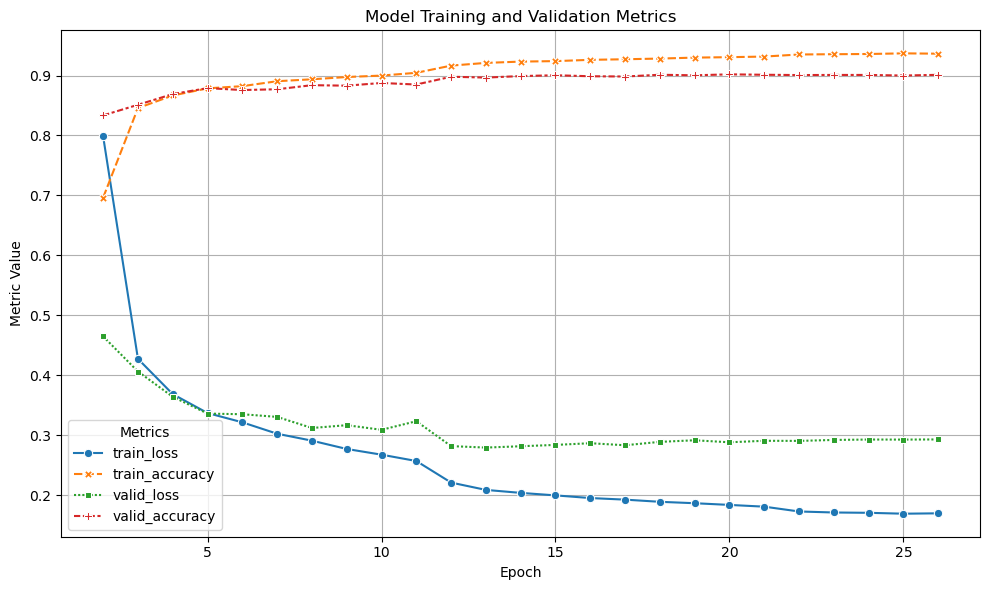

In [82]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=metrics_long, x='epoch', y='Value', hue='Metric', style='Metric', markers=True)

# Titiles, subtitles etc
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Model Training and Validation Metrics')
plt.legend(title='Metrics')
plt.grid(True)

plt.tight_layout()
plt.show()